In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import ta
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange

In [2]:
def adx(high, low, close, window=14):
    """
    Calculate the Average Directional Index (ADX).

    Parameters:
        high (pd.Series): Series of high prices
        low (pd.Series): Series of low prices
        close (pd.Series): Series of close prices
        window (int): The period over which to calculate the ADX (default is 14)

    Returns:
        pd.Series: ADX values indexed the same as the input data
    """
    # Calculate the components of the True Range
    tr = pd.Series(np.max([high - low, abs(high - close.shift(1)), abs(low - close.shift(1))], axis=0), index=close.index)
    tr_smoothed = tr.rolling(window=window, min_periods=1).sum()

    # Calculate +DM and -DM
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    minus_dm = minus_dm.abs()

    # Smooth +DM and -DM
    plus_dm_smoothed = plus_dm.rolling(window=window, min_periods=1).sum()
    minus_dm_smoothed = minus_dm.rolling(window=window, min_periods=1).sum()

    # Calculate +DI and -DI
    plus_di = 100 * plus_dm_smoothed / tr_smoothed
    minus_di = 100 * minus_dm_smoothed / tr_smoothed

    # Calculate DX
    dx = 100 * abs((plus_di - minus_di) / (plus_di + minus_di))

    # Calculate ADX
    adx = dx.rolling(window=window, min_periods=1).mean()

    return adx.rename('ADX')

In [3]:

ATR_LENGTH = 14
GRID_SIZE = 10
GRID_STEP = 1
data = pd.read_csv('../BTCdata_clean.csv')

#Add ATR and ADX feature indicators to dataset
data['ATR'] = AverageTrueRange(data['High Price'], data['Low Price'], data['Close Price'], window=ATR_LENGTH).average_true_range()
data['ADX'] = adx(data['High Price'], data['Low Price'], data['Close Price'], window=14)



trades = []


In [4]:
count = 0;
for i in range(len(data)):
    if data['ADX'][i] > 22:
        count = count + 1
print(count/len(data) * 100)
#check how often it spends trending (how tradeable)

68.4895773897828


In [31]:
def checkPrice(grid, idx, balance, ADXLimit = 20, ATRMultiplier = 1, verbose = 0):
    """
    Check the price at a given index and make a trade if conditions are met
    ADXLimit: ADX value above which the bot will liquidate positions and not trade
    ATRMultiplier: Multiplier for the ATR value to determine grid size
    """
    #if not enough data for ATR(typically 14), do nothing
    if(idx < ATR_LENGTH):
        return grid
    
    #get current price and ATR value
    atr = data['ATR'][idx]
    current_price = data['Close Price'][idx]
    if verbose:
        print('Current Price: ' + str(current_price))
        print('ADX: ' + str(data['ADX'][idx]))

    #if trending, clear grid and wait
    if(data['ADX'][idx] > ADXLimit):
        if verbose:
            print('Trending, clear grid and wait')
        balance.update({'money': balance['money'] + current_price*balance['coinage'], 'coinage': 0})
        grid['buy'].clear()
        grid['sell'].clear()

    #if conditions are met, make a new grid
    if(len(grid['buy']) == 0 or len(grid['sell']) ==0 ):
        grid = create_grid(current_price, grid, atr, ATRMultiplier)
        if verbose:
            print('New Grid Created:')

    #if price hits a level, buy or sell
    if current_price <= max(grid['buy']):
        balance.update({'money': balance['money'] - current_price, 'coinage': balance['coinage']+1})
        grid['buy'].remove(max(grid['buy']))
        if verbose:
            print('bought at ' + str(current_price))
        
        trades.append(('buy', current_price, idx))
    elif current_price >= min(grid['sell']):
        balance.update({'money': balance['money'] + current_price, 'coinage': balance['coinage']-1})
        grid['sell'].remove(min(grid['sell']))
        if verbose:
            print('sold at ' + str(current_price))
        trades.append(('sell', current_price, idx))

    #update maxDrawdown
    balance.update({'maxDrawdown': min(balance['maxDrawdown'], balance['money'])})
    return grid
def create_grid(current_price, grid, atr, ATRMultiplier = 1):
    step = atr*ATRMultiplier
    lower_bound = current_price - GRID_SIZE*step/2
    upper_bound = current_price + GRID_SIZE*step/2
    
    for i in range(5):
        
        grid['buy'].append(lower_bound + i*step)
        grid['sell'].append(upper_bound - i*step)
        
    return grid


In [62]:
def test_grid(ADXLimit, ATRMultiplier, data = data, dataLimit = 1000000, dataStart = 0):
    grid = {
    'buy' : [],
    'sell' : []
    }
    balance = {'money': 0, 'coinage' : 0, 'maxDrawdown': 0}
    
    # dataLimit = int(len(data['High Price'])/2)
    data = data[dataStart:dataLimit]
    for i in range(dataLimit):
        count = 0
        
        grid = checkPrice(grid= grid, idx=i+dataStart, balance=balance, ADXLimit = ADXLimit, ATRMultiplier = ATRMultiplier)

    print(balance)

    if(balance['coinage'] != 0):
        balance.update({'money': balance['money'] + data['Close Price'][dataLimit-1]*balance['coinage'], 'coinage': 0})
        print('Liquified Balance' + str(balance))
    return balance
dataLimit = 500000
dataStart = 495000
adxTests = [15, 20, 25, 30, 35, 40, 45, 50]
atrTests = [0.5, 1, 1.5, 2, 2.5, 3]
results = {}
for adx in adxTests:
    for atr in atrTests:
        print('Testing ADX: ' + str(adx) + ' ATR: ' + str(atr))
        results.update({str('ADX:'+str(adx) +' ATR: '+ str(atr)):test_grid(adx, atr, dataLimit = dataLimit, dataStart = dataStart)})


Testing ADX: 15 ATR: 0.5
{'money': -14063.680000000502, 'coinage': 0, 'maxDrawdown': -384679.1400000003}
Testing ADX: 15 ATR: 1
{'money': -6778.5199999995675, 'coinage': 0, 'maxDrawdown': -246595.7600000002}
Testing ADX: 15 ATR: 1.5
{'money': -4914.44999999975, 'coinage': 0, 'maxDrawdown': -184952.94999999984}
Testing ADX: 15 ATR: 2
{'money': -2872.740000000231, 'coinage': 0, 'maxDrawdown': -170447.5100000003}
Testing ADX: 15 ATR: 2.5
{'money': -1124.0999999998967, 'coinage': 0, 'maxDrawdown': -169669.00999999995}
Testing ADX: 15 ATR: 3
{'money': -1522.9200000000783, 'coinage': 0, 'maxDrawdown': -149896.59000000005}
Testing ADX: 20 ATR: 0.5
{'money': 12673.790000000125, 'coinage': 0, 'maxDrawdown': -615982.4699999997}
Testing ADX: 20 ATR: 1
{'money': 13831.200000000856, 'coinage': 0, 'maxDrawdown': -283193.32999999914}
Testing ADX: 20 ATR: 1.5
{'money': 11010.070000000414, 'coinage': 0, 'maxDrawdown': -251922.58000000016}
Testing ADX: 20 ATR: 2
{'money': 11256.760000000359, 'coinage': 

In [63]:
for i in results:
    results[i].update({'ratio': abs(results[i]['money']/results[i]['maxDrawdown'])})
sorted_dict_asc = dict(sorted(results.items(), key=lambda item: item[1]['ratio']))
print(dataLimit)
for i in sorted_dict_asc:
    print(i + ' : ' + str(sorted_dict_asc[i]))

500000
ADX:50 ATR: 0.5 : {'money': -253.41999999937252, 'coinage': 0, 'maxDrawdown': -759174.0199999993, 'ratio': 0.00033381015857124926}
ADX:15 ATR: 2.5 : {'money': -1124.0999999998967, 'coinage': 0, 'maxDrawdown': -169669.00999999995, 'ratio': 0.006625252307418408}
ADX:15 ATR: 3 : {'money': -1522.9200000000783, 'coinage': 0, 'maxDrawdown': -149896.59000000005, 'ratio': 0.010159804168994624}
ADX:15 ATR: 2 : {'money': -2872.740000000231, 'coinage': 0, 'maxDrawdown': -170447.5100000003, 'ratio': 0.016854103647511342}
ADX:25 ATR: 3 : {'money': 3442.640000000014, 'coinage': 0, 'maxDrawdown': -197321.4699999999, 'ratio': 0.017446859685365284}
ADX:20 ATR: 0.5 : {'money': 12673.790000000125, 'coinage': 0, 'maxDrawdown': -615982.4699999997, 'ratio': 0.020574919932380753}
ADX:20 ATR: 3 : {'money': 3932.8000000003813, 'coinage': 0, 'maxDrawdown': -181686.05999999965, 'ratio': 0.02164612959299348}
ADX:45 ATR: 2.5 : {'money': 8965.33000000078, 'coinage': 0, 'maxDrawdown': -413458.0899999988, 'rat

In [66]:
sorted_dict_asc = dict(sorted(results.items(), key=lambda item: item[1]['money']))
print('trade time ' + str(dataLimit-dataStart))
for i in sorted_dict_asc:
    print(i + ' : ' + str(sorted_dict_asc[i]))

trade time 5000
ADX:50 ATR: 2.5 : {'money': -83974.56000000039, 'coinage': 0, 'maxDrawdown': -480145.19000000047, 'ratio': 0.17489409817892856}
ADX:50 ATR: 1 : {'money': -66734.05000000211, 'coinage': 0, 'maxDrawdown': -784759.7500000016, 'ratio': 0.08503755448721978}
ADX:50 ATR: 2 : {'money': -59528.349999998885, 'coinage': 0, 'maxDrawdown': -524880.31, 'ratio': 0.11341318938025867}
ADX:50 ATR: 3 : {'money': -55978.2700000004, 'coinage': 0, 'maxDrawdown': -399445.5400000001, 'ratio': 0.14013992996392044}
ADX:50 ATR: 1.5 : {'money': -14592.900000000533, 'coinage': 0, 'maxDrawdown': -583794.8500000002, 'ratio': 0.024996623385767323}
ADX:15 ATR: 0.5 : {'money': -14063.680000000502, 'coinage': 0, 'maxDrawdown': -384679.1400000003, 'ratio': 0.03655950774975865}
ADX:15 ATR: 1 : {'money': -6778.5199999995675, 'coinage': 0, 'maxDrawdown': -246595.7600000002, 'ratio': 0.02748838828372216}
ADX:15 ATR: 1.5 : {'money': -4914.44999999975, 'coinage': 0, 'maxDrawdown': -184952.94999999984, 'ratio': 

In [67]:
import csv
filepath = 'gridTest.csv'

testResults = {'testing': {'money': 100, 'coinage': 0, 'maxDrawdown': 0}}

#write results to csv
with open('gridTest.csv', mode='a' if os.path.exists(filepath) else 'w', newline='') as file:
    # Fields including the main key plus nested keys
    fieldnames = ['parameters', 'money', 'coinage', 'maxDrawdown', 'ratio']

    writer = csv.DictWriter(file, fieldnames=fieldnames)
    if not os.path.exists(filepath):
        writer.writeheader()
    
    # Iterate through the main dictionary
    for key, nested_dict in results.items():
        # `key` is something like "ADX:15 ATR: 0.5", we include it under 'parameters'
        row_data = {'parameters': key}
        row_data.update(nested_dict)  # Merge the nested dict into our row dict
        writer.writerow(row_data)


ValueError: dict contains fields not in fieldnames: 'ratio'

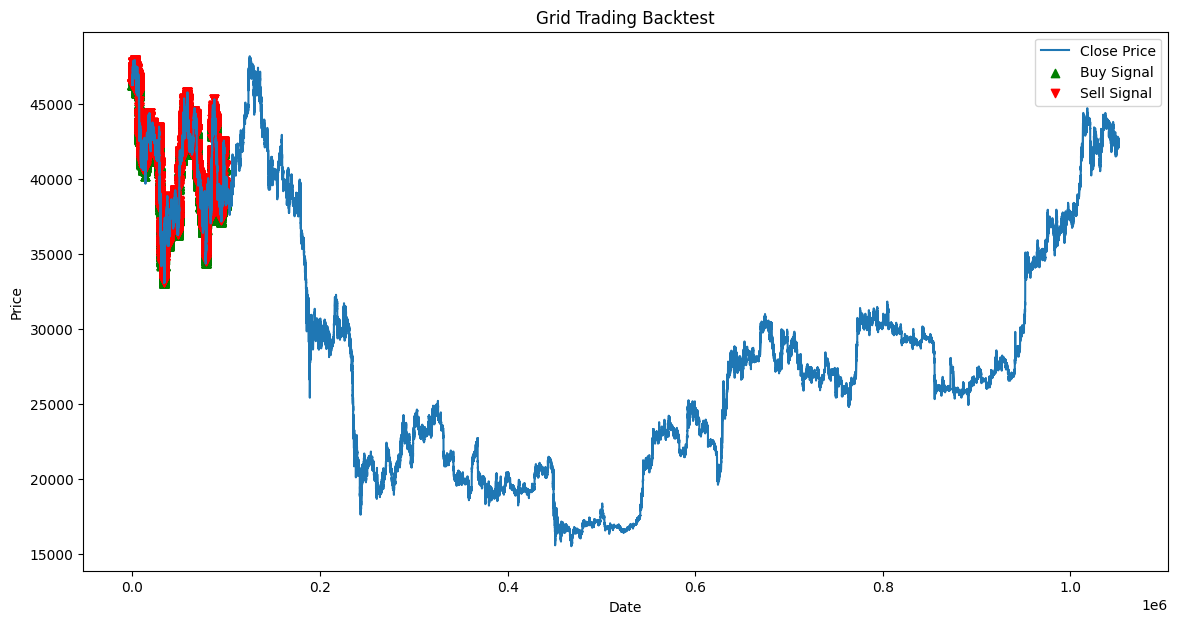

In [8]:
# Extract buy and sell points for plotting
buys = [data['Close Price'].iloc[i] for action, price, i in trades if action == 'buy']
sells = [data['Close Price'].iloc[i] for action, price, i in trades if action == 'sell']
buy_indices = [i for action, price, i in trades if action == 'buy']
sell_indices = [i for action, price, i in trades if action == 'sell']



# Plotting results
plt.figure(figsize=(14, 7))
plt.plot(data['Close Price'], label='Close Price')
plt.scatter(buy_indices, buys, color='green', label='Buy Signal', marker='^', alpha=1)
plt.scatter(sell_indices, sells, color='red', label='Sell Signal', marker='v', alpha=1)
plt.title('Grid Trading Backtest')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()